In [7]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [8]:
import torch
from pathlib import Path
import os
import json
import matplotlib.pyplot as plt
import pandas as pd

import pytorch_lightning as pl
from pytorch_lightning.callbacks import LearningRateMonitor, ModelCheckpoint
from sklearn.metrics import mean_squared_error

from Iwildcam_Pretrain import Autoencoder, IWildCamDataset
from lora_modules import LoRAConv2d, LoRALinear, LoRAConvTranspose2d

In [9]:
device = torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu")
print("Device:", device)

CHECKPOINT_PATH = "checkpoints/"
HEIGHT = 96
WIDTH = 160
PRECISION = 32

Device: cuda:0


In [10]:
loraize_encoder = False  # no reason really to do this unless we want to reduce memory footprint
loraize_decoder = True 

lora_config = {
    torch.nn.Conv2d: {
        'cls': LoRAConv2d,
        'config': {
            'alpha': 8,
            'rank': 4,
            'rank_for': 'channels',
            'delta_bias': False # True # TODO what does this do
        }
    },
    torch.nn.Linear: {
        'cls': LoRALinear,
        'config': {
            'rank': 4,
            'alpha': 2,
            'delta_bias':  False # True # TODO what does this do
        }
    },
    torch.nn.ConvTranspose2d: {
        'cls': LoRAConvTranspose2d,
        'config': {
            'alpha': 8,
            'rank': 4,
            'rank_for': 'channels',
            'delta_bias': False # True # TODO what does this do
        }
    }
}

def get_lora_model(latent_dim):
    # load two copies so we can lora-ize one
    pretrained_filename = os.path.join(CHECKPOINT_PATH, f"iwildcam_{latent_dim}.ckpt")
    if os.path.isfile(pretrained_filename):
        print(f"Found pretrained model for latent dim {latent_dim}, loading...")
        _model = Autoencoder.load_from_checkpoint(pretrained_filename)
        model = Autoencoder.load_from_checkpoint(pretrained_filename)
    else:
        raise Exception

    if loraize_encoder:
        for i, module in enumerate(_model.encoder.net.children()): 
            if type(module) in lora_config.keys():
                lora_cls = lora_config[type(module)]['cls']
                lora_params = lora_config[type(module)]['config']
                model.encoder.net[i] = lora_cls(module, lora_params) # automatically freezes old parameters
                model.encoder.net[i].enable_adapter()                # but we need to turn on the adapter path

    if loraize_decoder:
        for i, module in enumerate(_model.decoder.linear.children()): 
            if type(module) in lora_config.keys():
                lora_cls = lora_config[type(module)]['cls']
                lora_params = lora_config[type(module)]['config']
                model.decoder.linear[i] = lora_cls(module, lora_params) # automatically freezes old parameters
                model.decoder.linear[i].enable_adapter()                # but we need to turn on the adapter path

        for i, module in enumerate(_model.decoder.net.children()): 
            if type(module) in lora_config.keys():
                lora_cls = lora_config[type(module)]['cls']
                lora_params = lora_config[type(module)]['config']
                model.decoder.net[i] = lora_cls(module, lora_params) # automatically freezes old parameters
                model.decoder.net[i].enable_adapter()                # but we need to turn on the adapter path

    del _model # get rid of the clone
    return model

  0%|          | 0/60029 [00:00<?, ?it/s]

Failed to read image '/data/vision/beery/scratch/data/iwildcam_unzipped/test/8e940310-21bc-11ea-a13a-137349068a90.jpg'. Replacing with zero tensor. Full exception: broken data stream when reading image file
Failed to read image '/data/vision/beery/scratch/data/iwildcam_unzipped/test/96bacf06-21bc-11ea-a13a-137349068a90.jpg'. Replacing with zero tensor. Full exception: broken data stream when reading image file
Failed to read image '/data/vision/beery/scratch/data/iwildcam_unzipped/test/8fff9dc2-21bc-11ea-a13a-137349068a90.jpg'. Replacing with zero tensor. Full exception: broken data stream when reading image file
Failed to read image '/data/vision/beery/scratch/data/iwildcam_unzipped/test/8e930668-21bc-11ea-a13a-137349068a90.jpg'. Replacing with zero tensor. Full exception: broken data stream when reading image file
Failed to read image '/data/vision/beery/scratch/data/iwildcam_unzipped/test/950ed288-21bc-11ea-a13a-137349068a90.jpg'. Replacing with zero tensor. Full exception: broken d

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type    | Params | Mode  | In sizes        | Out sizes      
--------------------------------------------------------------------------------
0 | encoder | Encoder | 4.0 M  | train | [2, 3, 160, 96] | [2, 256]       
1 | decoder | Decoder | 4.1 M  | train | [2, 256]        | [2, 3, 96, 160]
--------------------------------------------------------------------------------
4.1 M     Trainable params
4.0 M     Non-trainable params
8.2 M     Total params
32.654    Total estimated model params size (MB)
35        Modules in train mode
0         Modules in eval mode


Autoencoder(
  (encoder): Encoder(
    (net): Sequential(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (1): GELU(approximate='none')
      (2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (3): GELU(approximate='none')
      (4): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (5): GELU(approximate='none')
      (6): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (7): GELU(approximate='none')
      (8): Conv2d(64, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (9): GELU(approximate='none')
      (10): Flatten(start_dim=1, end_dim=-1)
      (11): Linear(in_features=15360, out_features=256, bias=True)
    )
  )
  (decoder): Decoder(
    (linear): Sequential(
      (0): LoRALinear(Linear(in_features=256, out_features=15360, bias=True) + ((α=2.0/r=4) × Adapter(in_features=256, rank=4, out_features=15360)))
      (1): GELU(approximate='none')
    )
    (net): Sequen

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=100` reached.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/data/vision/beery/scratch/justin/envs/aecompression/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:424: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.


Testing: |          | 0/? [00:00<?, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss             5017.7373046875
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Loading cache /tmp/aecompression-cache/datasets/test_160_96_32.pt
Finished loading cache /tmp/aecompression-cache/datasets/test_160_96_32.pt of shape torch.Size([60029, 3, 96, 160])
Found pretrained model for latent dim 256, loading...


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Autoencoder(
  (encoder): Encoder(
    (net): Sequential(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (1): GELU(approximate='none')
      (2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (3): GELU(approximate='none')
      (4): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (5): GELU(approximate='none')
      (6): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (7): GELU(approximate='none')
      (8): Conv2d(64, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (9): GELU(approximate='none')
      (10): Flatten(start_dim=1, end_dim=-1)
      (11): Linear(in_features=15360, out_features=256, bias=True)
    )
  )
  (decoder): Decoder(
    (linear): Sequential(
      (0): LoRALinear(Linear(in_features=256, out_features=15360, bias=True) + ((α=2.0/r=4) × Adapter(in_features=256, rank=4, out_features=15360)))
      (1): GELU(approximate='none')
    )
    (net): Sequen


  | Name    | Type    | Params | Mode  | In sizes        | Out sizes      
--------------------------------------------------------------------------------
0 | encoder | Encoder | 4.0 M  | train | [2, 3, 160, 96] | [2, 256]       
1 | decoder | Decoder | 4.1 M  | train | [2, 256]        | [2, 3, 96, 160]
--------------------------------------------------------------------------------
4.1 M     Trainable params
4.0 M     Non-trainable params
8.2 M     Total params
32.654    Total estimated model params size (MB)
35        Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/data/vision/beery/scratch/justin/envs/aecompression/lib/python3.9/site-packages/pytorch_lightning/loops/fit_loop.py:298: The number of training batches (1) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=100` reached.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: |          | 0/? [00:00<?, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss            4585.66552734375
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Loading cache /tmp/aecompression-cache/datasets/test_160_96_32.pt
Finished loading cache /tmp/aecompression-cache/datasets/test_160_96_32.pt of shape torch.Size([60029, 3, 96, 160])
Found pretrained model for latent dim 256, loading...
Autoencoder(
  (encoder): Encoder(
    (net): Sequential(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (1): GELU(approximate='none')
      (2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (3): GELU(approximate='none')
      (4): Conv2d(32, 64, ke

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type    | Params | Mode  | In sizes        | Out sizes      
--------------------------------------------------------------------------------
0 | encoder | Encoder | 4.0 M  | train | [2, 3, 160, 96] | [2, 256]       
1 | decoder | Decoder | 4.1 M  | train | [2, 256]        | [2, 3, 96, 160]
--------------------------------------------------------------------------------
4.1 M     Trainable params
4.0 M     Non-trainable params
8.2 M     Total params
32.654    Total estimated model params size (MB)
35        Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/data/vision/beery/scratch/justin/envs/aecompression/lib/python3.9/site-packages/pytorch_lightning/loops/fit_loop.py:298: The number of training batches (20) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=100` reached.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: |          | 0/? [00:00<?, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss            5452.08447265625
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Loading cache /tmp/aecompression-cache/datasets/test_160_96_32.pt
Finished loading cache /tmp/aecompression-cache/datasets/test_160_96_32.pt of shape torch.Size([60029, 3, 96, 160])
Found pretrained model for latent dim 256, loading...


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type    | Params | Mode  | In sizes        | Out sizes      
--------------------------------------------------------------------------------
0 | encoder | Encoder | 4.0 M  | train | [2, 3, 160, 96] | [2, 256]       
1 | decoder | Decoder | 4.1 M  | train | [2, 256]        | [2, 3, 96, 160]
--------------------------------------------------------------------------------
4.1 M     Trainable params
4.0 M     Non-trainable params
8.2 M     Total params
32.654    Total estimated model params size (MB)
35        Modules in train mode
0         Modules in eval mode


Autoencoder(
  (encoder): Encoder(
    (net): Sequential(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (1): GELU(approximate='none')
      (2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (3): GELU(approximate='none')
      (4): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (5): GELU(approximate='none')
      (6): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (7): GELU(approximate='none')
      (8): Conv2d(64, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (9): GELU(approximate='none')
      (10): Flatten(start_dim=1, end_dim=-1)
      (11): Linear(in_features=15360, out_features=256, bias=True)
    )
  )
  (decoder): Decoder(
    (linear): Sequential(
      (0): LoRALinear(Linear(in_features=256, out_features=15360, bias=True) + ((α=2.0/r=4) × Adapter(in_features=256, rank=4, out_features=15360)))
      (1): GELU(approximate='none')
    )
    (net): Sequen

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/data/vision/beery/scratch/justin/envs/aecompression/lib/python3.9/site-packages/pytorch_lightning/loops/fit_loop.py:298: The number of training batches (17) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=100` reached.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: |          | 0/? [00:00<?, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss             9708.775390625
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Loading cache /tmp/aecompression-cache/datasets/test_160_96_32.pt
Finished loading cache /tmp/aecompression-cache/datasets/test_160_96_32.pt of shape torch.Size([60029, 3, 96, 160])
Found pretrained model for latent dim 256, loading...


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type    | Params | Mode  | In sizes        | Out sizes      
--------------------------------------------------------------------------------
0 | encoder | Encoder | 4.0 M  | train | [2, 3, 160, 96] | [2, 256]       
1 | decoder | Decoder | 4.1 M  | train | [2, 256]        | [2, 3, 96, 160]
--------------------------------------------------------------------------------
4.1 M     Trainable params
4.0 M     Non-trainable params
8.2 M     Total params
32.654    Total estimated model params size (MB)
35        Modules in train mode
0         Modules in eval mode


Autoencoder(
  (encoder): Encoder(
    (net): Sequential(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (1): GELU(approximate='none')
      (2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (3): GELU(approximate='none')
      (4): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (5): GELU(approximate='none')
      (6): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (7): GELU(approximate='none')
      (8): Conv2d(64, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (9): GELU(approximate='none')
      (10): Flatten(start_dim=1, end_dim=-1)
      (11): Linear(in_features=15360, out_features=256, bias=True)
    )
  )
  (decoder): Decoder(
    (linear): Sequential(
      (0): LoRALinear(Linear(in_features=256, out_features=15360, bias=True) + ((α=2.0/r=4) × Adapter(in_features=256, rank=4, out_features=15360)))
      (1): GELU(approximate='none')
    )
    (net): Sequen

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=100` reached.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: |          | 0/? [00:00<?, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss                19261.875
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


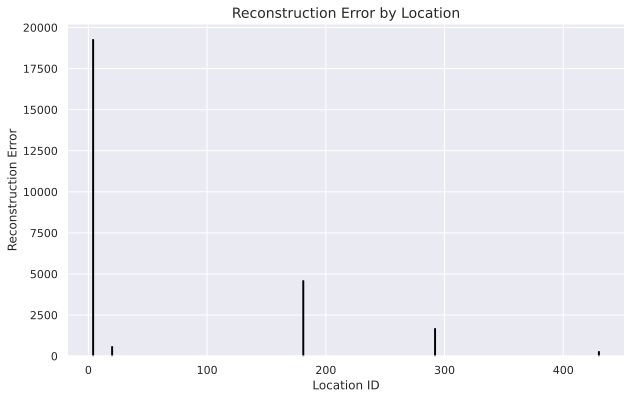

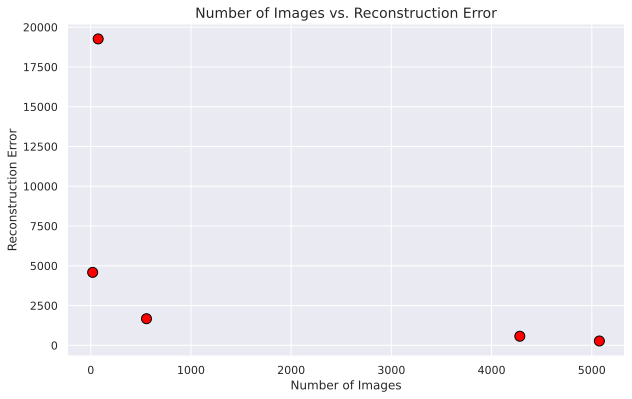

In [11]:
our_test_set_ids = [292, 181, 430, 20, 4]
latent_dim = 256

results = []

for loc_id in our_test_set_ids:
    test_set = IWildCamDataset(Path("/data/vision/beery/scratch/data/iwildcam_unzipped"), split="test")
    test_set.cache_on_device_(device)
    test_set._cache = test_set._cache[[idx for idx, i in enumerate(test_set.data['images']) if i['location'] == loc_id]]
    test_set.data['images'] = [i for i in test_set.data['images'] if i['location'] == loc_id]
    test_loader = torch.utils.data.DataLoader(test_set, batch_size=256, shuffle=False, drop_last=False, num_workers=0)

    model = get_lora_model(latent_dim)
    print(model)
    
    # Freeze decoder if specified
    # TODO remove this once lora-ize decoder works
    # freeze_decoder = True
    # if freeze_decoder:
    # for param in model.decoder.parameters():
    #     param.requires_grad = False
    # print(f"Decoder frozen for location {loc_id}")

    trainer = pl.Trainer(
        default_root_dir=os.path.join(CHECKPOINT_PATH, f"iwildcam_loc_{loc_id}"),
        accelerator="gpu" if str(device).startswith("cuda") else "cpu",
        precision=PRECISION,
        devices=1,
        max_epochs=100,
        callbacks=[
            ModelCheckpoint(save_weights_only=True),
            LearningRateMonitor("epoch")
        ]
    )

    # Train the model
    # Overfit to the test set
    trainer.fit(model, test_loader, test_loader)
    save_path = os.path.join(CHECKPOINT_PATH, f"iwildcam_latent_dim={latent_dim}_lora_loc={loc_id}.ckpt")
    trainer.save_checkpoint(save_path)

    test_reconstruction_error = trainer.test(model=model, dataloaders=test_loader)[0]['test_loss']
    test_reconstruction_error /= len(test_loader) # TODO: I think what we get from test() is a sum over batches?

    # Store results
    results.append((loc_id, len(test_set.data['images']), test_reconstruction_error))

    # release memory
    del test_set
    del model
    del trainer
    torch.cuda.empty_cache()

# Step 6: Visualize the results
# Bar chart of reconstruction error by location
locations, num_images, errors = zip(*results)

# Bar chart
plt.figure(figsize=(10, 6))
plt.bar(locations, errors, color='skyblue', edgecolor='black')
plt.xlabel("Location ID", fontsize=12)
plt.ylabel("Reconstruction Error", fontsize=12)
plt.title("Reconstruction Error by Location", fontsize=14)
plt.grid(True)
plt.show()

# Scatter plot of number of images vs. reconstruction error
plt.figure(figsize=(10, 6))
plt.scatter(num_images, errors, color='red', edgecolor='black', s=100)
plt.xlabel("Number of Images", fontsize=12)
plt.ylabel("Reconstruction Error", fontsize=12)
plt.title("Number of Images vs. Reconstruction Error", fontsize=14)
plt.grid(True)
plt.show()

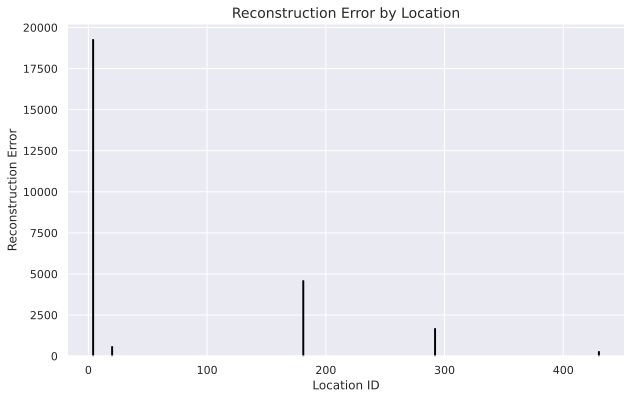

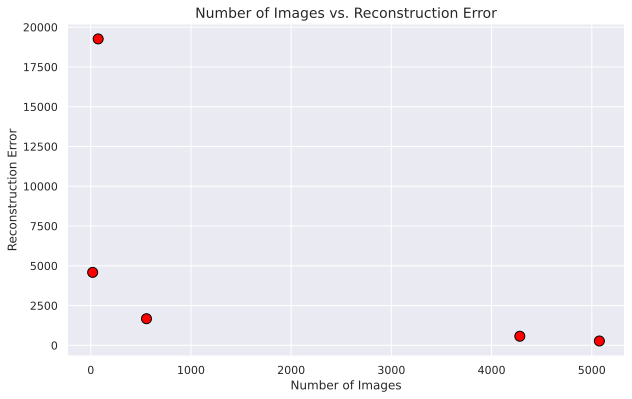

In [14]:
# Step 6: Visualize the results
# Bar chart of reconstruction error by location
locations, num_images, errors = zip(*results)

# Bar chart
plt.figure(figsize=(10, 6))
plt.bar(locations, errors, color='skyblue', edgecolor='black')
plt.xlabel("Location ID", fontsize=12)
plt.ylabel("Reconstruction Error", fontsize=12)
plt.title("Reconstruction Error by Location", fontsize=14)
plt.grid(True)
plt.show()

# Scatter plot of number of images vs. reconstruction error
plt.figure(figsize=(10, 6))
plt.scatter(num_images, errors, color='red', edgecolor='black', s=100)
plt.xlabel("Number of Images", fontsize=12)
plt.ylabel("Reconstruction Error", fontsize=12)
plt.title("Number of Images vs. Reconstruction Error", fontsize=14)
plt.grid(True)
plt.show()

In [16]:
# param_size = 0
# for name, param in model.named_parameters():
#     if "delta" in name:
#         param_size += param.nelement() * param.element_size()

# # assume we don't have to transmit these if they are fixed -- this would be alpha, rank hyperparams
# buffer_size = 0

# size_all_mb = (param_size + buffer_size) / 1024**2
# print('decoder lora weight size: {:.3f}MB'.format(size_all_mb))